In [ ]:
import pandas as pd
import cv2
import numpy as np
import faiss

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### CNN EMBEDDINGS

Read paths

In [2]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

Fine Tuning VGG16 (link of the model: https://drive.google.com/file/d/1h_h_FCyDz-XQuEYm-gRbbEDVLGHJerMN/view?usp=sharing)

In [ ]:
# Semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Cargar rutas de imágenes y etiquetas
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]
labels = paths_db['label'].astype('category').cat.codes.values.tolist()  # Convertir etiquetas a índices

# Crear un generador de datos para el entrenamiento
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Preprocesamiento específico de VGG16
)

# Generador de entrenamiento
train_generator = datagen.flow_from_dataframe(
    dataframe=paths_db,  # Usar el DataFrame para obtener imágenes y etiquetas
    directory="images",  # Directorio donde están las imágenes
    x_col="image",  # Columna de las rutas de las imágenes
    y_col="label",  # Columna de las etiquetas
    target_size=(224, 224),  # Tamaño de las imágenes
    batch_size=32,  # Tamaño del batch
    class_mode="sparse",  # Usar índices de clases en lugar de one-hot encoding
    shuffle=True  # Aleatorizar los datos
)

# Cargar la VGG16 preentrenada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
embeddings = Dense(1024, activation='softmax')(x)  # Número de clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=embeddings)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Índices de clase como etiquetas
              metrics=['accuracy'])

# Entrenar el modelo con todas las imágenes
model.fit(train_generator, epochs=5)

# Fine-tuning: Descongelar las últimas capas de la base
for layer in base_model.layers[-4:]:  # Ajusta el número de capas a descongelar
    layer.trainable = True

# Compilar nuevamente con una tasa de aprendizaje baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar nuevamente
model.fit(train_generator, epochs=5)

# Guardar el modelo entrenado
model.save("fine_tuned_model.h5")

Found 500 validated image filenames belonging to 5 classes.
Epoch 1/5
16/16 [==============================] - 124s 8s/step - loss: 2.4311 - accuracy: 0.5480
Epoch 2/5
16/16 [==============================] - 123s 8s/step - loss: 0.5245 - accuracy: 0.8500
Epoch 3/5
16/16 [==============================] - 79s 5s/step - loss: 0.2996 - accuracy: 0.9040
Epoch 4/5
16/16 [==============================] - 75s 5s/step - loss: 0.1707 - accuracy: 0.9400
Epoch 5/5
16/16 [==============================] - 69s 4s/step - loss: 0.1560 - accuracy: 0.9480
Epoch 1/5
16/16 [==============================] - 95s 6s/step - loss: 0.3239 - accuracy: 0.9200
Epoch 2/5
16/16 [==============================] - 103s 6s/step - loss: 0.1097 - accuracy: 0.9680
Epoch 3/5
16/16 [==============================] - 88s 5s/step - loss: 0.1165 - accuracy: 0.9620
Epoch 4/5
16/16 [==============================] - 101s 6s/step - loss: 0.0570 - accuracy: 0.9840
Epoch 5/5
16/16 [==============================] - 102s 6s/step

In [10]:
def extract_cnn_features(img):
    image = img / 255.0
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    embedding = model.predict(image)
    return np.array([embedding.flatten()], dtype=np.float32)

In [11]:
cnn_embeddings = []
dimension = 1024

for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    features = extract_cnn_features(image)
    print(features.shape)
    cnn_embeddings.append(features.reshape(dimension))

features = np.array(cnn_embeddings)

1/1 [==============================] - 1s 552ms/step
(1, 1024)
1/1 [==============================] - 0s 226ms/step
(1, 1024)
1/1 [==============================] - 0s 169ms/step
(1, 1024)
1/1 [==============================] - 0s 171ms/step
(1, 1024)
1/1 [==============================] - 0s 190ms/step
(1, 1024)
1/1 [==============================] - 0s 220ms/step
(1, 1024)
1/1 [==============================] - 0s 170ms/step
(1, 1024)
1/1 [==============================] - 0s 183ms/step
(1, 1024)
1/1 [==============================] - 0s 212ms/step
(1, 1024)
1/1 [==============================] - 0s 199ms/step
(1, 1024)
1/1 [==============================] - 0s 173ms/step
(1, 1024)
1/1 [==============================] - 0s 183ms/step
(1, 1024)
1/1 [==============================] - 0s 170ms/step
(1, 1024)
1/1 [==============================] - 0s 166ms/step
(1, 1024)
1/1 [==============================] - 0s 177ms/step
(1, 1024)
1/1 [==============================] - 0s 155ms/step
(1

Creation of the index

In [12]:
index = faiss.IndexFlatL2(dimension)

vectores = np.array(features)

faiss.normalize_L2(vectores)

index.add(vectores)

In [13]:
faiss.write_index(index, 'database\cnn.index')

Test

1/1 [==============================] - 0s 161ms/step
Distances:  [[0.         0.00126968 0.0014033  0.00146038 0.00150782]]
Indices:  [[ 14   9  28 295  83]]


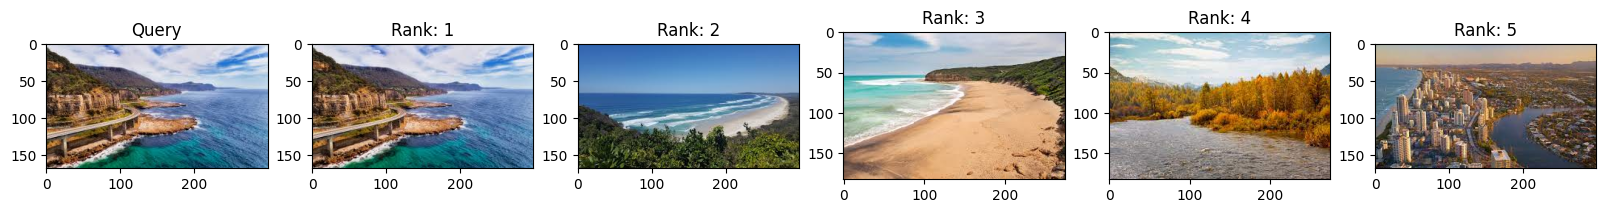

In [21]:
index = faiss.read_index("database/cnn.index")

img_test = "images\Training Data\Coast\Coast-Train (1010).jpeg"

img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

query = extract_cnn_features(img).reshape(dimension)

query = np.array([query])

faiss.normalize_L2(query)

k = 5
distances, indices = index.search(query, k)

print("Distances: ", distances)
print("Indices: ", indices)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Query")

for i in range(5):
    img = cv2.imread(paths[indices[0][i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 6, i+2)
    plt.imshow(img)
    plt.title("Rank: " + str(i+1))

plt.show()